# 4. 3D Unet

5 month input

In [1]:
import tensorflow as tf
from models.grid_to_grid import unet3d
from utils.metrics import *
from utils.helpers import *
import models.masked_unet_loss as mul

import numpy as np
import xarray as xr
import geopandas as gpd

from livelossplot.inputs.keras import PlotLossesCallback
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

2025-11-17 13:30:00.658370: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-17 13:30:00.680870: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
root_path = './data/Bangladesh'
img_input_path = f"{root_path}/inputs/processed/image_%s.npy"

fill_value = -1
lag = 5

In [3]:
cv_setup = np.load(f'{root_path}/cv_setup.npy', allow_pickle=True).item()
train_ids = cv_setup['train_ids']
holdout_ids = cv_setup['holdout_ids']
tr_idxs = cv_setup['tr_idxs']
test_idxs = cv_setup['test_idxs']
seed = cv_setup['seed']

tf.random.set_seed(seed)

In [4]:
bgd_shp = gpd.read_file(f'{root_path}/BGD_shp/vb025yv7599.shp')
info_file = pd.read_csv(f'{root_path}/target/well_info.csv')
full_ndvi_da = xr.open_mfdataset(f'{root_path}/inputs/NDVI_M_2002_2017_BGD_025.nc4')['NDVI'][(lag-1):]
full_ndvi_da['time'] = [x + pd.DateOffset(days=14) for x in full_ndvi_da['time'].values ]

In [5]:
filled_ts = pd.read_csv(f"{root_path}/target/filtered_filled_missForest_gws_ts_data_1961_2019.csv", parse_dates=['Date'], index_col='Date')
filled_ts = filled_ts['2002-04-01':'2017-05-31'].dropna(axis=1, how='any')
filled_ts_gwsa = filled_ts - filled_ts['2004-01-01':'2009-12-31'].mean()

df_train = filled_ts_gwsa[train_ids].iloc[(lag-1):]

In [6]:
target_da = xr.full_like(full_ndvi_da, fill_value=None).rename('gwsa')
info_file_filtered = info_file[info_file['OldID'].isin(train_ids)]
start_date = df_train.index[0].strftime('%Y-%m-%d')

info_file_filtered["grid_cell"] = info_file_filtered.apply(
    lambda row: assign_to_grid((row["Latitude"], row["Longitude"]), 
                               full_ndvi_da.lat.values, 
                               full_ndvi_da.lon.values), axis=1
)

# Group the points by their grid cell
grouped_points = info_file_filtered.groupby("grid_cell")

for grid_cell, group in grouped_points:
    series_list = [filled_ts_gwsa.loc[:, wid] for wid in group.SegmentID]
    cc_df = pd.concat(series_list, axis=1)

    mean_values = cc_df.mean(axis=1)

    time_indexer = xr.DataArray(
        [months_between_dates(start_date, t.strftime("%Y-%m-%d"))
         for t in mean_values.index],
        dims=["time_src"],
    )

    tmp = xr.DataArray(mean_values.values, dims=["time_src"])

    arr1d = np.full((target_da.sizes["time"],), np.nan, dtype=target_da.dtype)
    arr1d[time_indexer.values] = tmp.values  # vectorized scatter

    target_da[:, grid_cell[0], grid_cell[1]] = xr.DataArray(
        arr1d, dims=["time"], coords={"time": target_da.time}
    )

/tmp/ipykernel_46860/2931934483.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  info_file_filtered["grid_cell"] = info_file_filtered.apply(


In [7]:
unet3d((lag,24,24,5)).summary()

Model: "UNet3D_reg"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 5, 24, 24, 5)]       0         []                            
                                                                                                  
 conv3d (Conv3D)             (None, 5, 24, 24, 16)        2176      ['input_1[0][0]']             
                                                                                                  
 conv3d_1 (Conv3D)           (None, 5, 24, 24, 16)        6928      ['conv3d[0][0]']              
                                                                                                  
 drop_c1 (Dropout)           (None, 5, 24, 24, 16)        0         ['conv3d_1[0][0]']            
                                                                                         

In [9]:
for k, (tr_idx, val_test_idx) in enumerate(zip(tr_idxs, test_idxs)):
    model = unet3d((lag,24,24,5))

    val_idx, tes_idx = val_test_idx[:int(len(val_test_idx)/2)], val_test_idx[int(len(val_test_idx)/2):]

    y_fold_tr = target_da[tr_idx]
    y_fold_val = target_da[val_idx]

    y_min, y_max = y_fold_tr.min().values.item(), y_fold_tr.max().values.item()
    y_fold_tr_scaled = (y_fold_tr - y_min)/(y_max - y_min)
    y_fold_val_scaled = (y_fold_val - y_min)/(y_max - y_min)
    Y_tr = y_fold_tr_scaled.fillna(fill_value).to_numpy()[..., np.newaxis]
    Y_val = y_fold_val_scaled.fillna(fill_value).to_numpy()[..., np.newaxis]

    input_train = np.stack([ np.stack(
        [ np.load(img_input_path % t) for t in range(i - (lag - 1), i + 1)], axis=0) for i in (tr_idx + (lag-1)) ], axis=0
    )
    input_val = np.stack([ np.stack(
        [ np.load(img_input_path % t) for t in range(i - (lag - 1), i + 1)], axis=0) for i in (val_idx + (lag-1)) ], axis=0
    )
    input_test = np.stack([ np.stack(
        [ np.load(img_input_path % t) for t in range(i - (lag - 1), i + 1)], axis=0) for i in (tes_idx + (lag-1)) ], axis=0
    )

    input_train[input_train == -1] = np.nan
    input_val[input_val == -1] = np.nan
    input_test[input_test == -1] = np.nan

    x_min, x_max = np.nanmin(input_train, axis=(0,1,2,3)), np.nanmax(input_train, axis=(0,1,2,3))
    X_tr = (input_train - x_min) / (x_max - x_min)
    X_val = (input_val - x_min) / (x_max - x_min)
    X_test = (input_test - x_min) / (x_max - x_min)
    X_tr[np.isnan(X_tr)] = -1
    X_val[np.isnan(X_val)] = -1
    X_test[np.isnan(X_test)] = -1

    mask_train = np.where(X_tr == -1, 0, 1)
    mask_val = np.where(X_val == -1, 0, 1)
    mask_test = np.where(X_test == -1, 0, 1)

    masked_loss = mul.make_masked_mse_with_trend(mul._resize_bool_mask(Y_tr[0] != -1))
    model.compile(optimizer='adam', loss = masked_loss, metrics = [ 'mse' ])

    model.fit(X_tr,
          Y_tr,
          batch_size=10,
          epochs=60,
          validation_data=[X_val, Y_val],
          callbacks=[
              # ModelCheckpoint(filepath='unet.weights.best.hdf5',
              #                 save_best_only=True,
              #                 verbose=1),
              #EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
              ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5),
              #PlotLossesCallback()
          ],
          verbose=0)

    full_pred_target = model.predict(
        np.concatenate((X_tr, X_val, X_test), axis=0),
        batch_size=5)

    dates = target_da.time[:(tes_idx[-1]+1)]
    full_pred_target_da = xr.DataArray(np.squeeze(full_pred_target), coords={'time': dates,'lat': target_da.lat, 'lon': target_da.lon}, dims=['time', 'lat', 'lon'])
    
    # clip to Bangladesh
    full_pred_target_da = full_pred_target_da.rio.set_spatial_dims(x_dim='lon', y_dim='lat', inplace=True)
    full_pred_target_da = full_pred_target_da.rio.write_crs("epsg:4326", inplace=True)
    full_pred_target_da = full_pred_target_da.rio.clip(bgd_shp.geometry.values, bgd_shp.crs, all_touched=True)
    
    denorm_pred_da = full_pred_target_da * (y_max - y_min) + y_min

    (
        denorm_pred_da.to_dataset(name=f'gwsa_pred')
            .to_netcdf(f'{root_path}/outputs/3D_Unet/3d_unet_filled_gwsa_{lag}m_fold_{k}.nc4')
    )

36/36 [==============================] - 1s 11ms/step


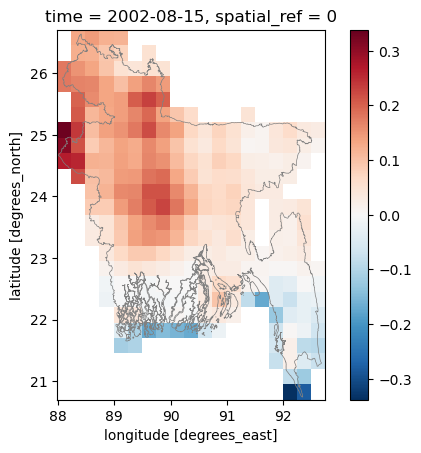

In [11]:
bgd_shp.boundary.plot(color='gray', linewidth=0.5)
denorm_pred_da[0].plot()